### Import resources and load data

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


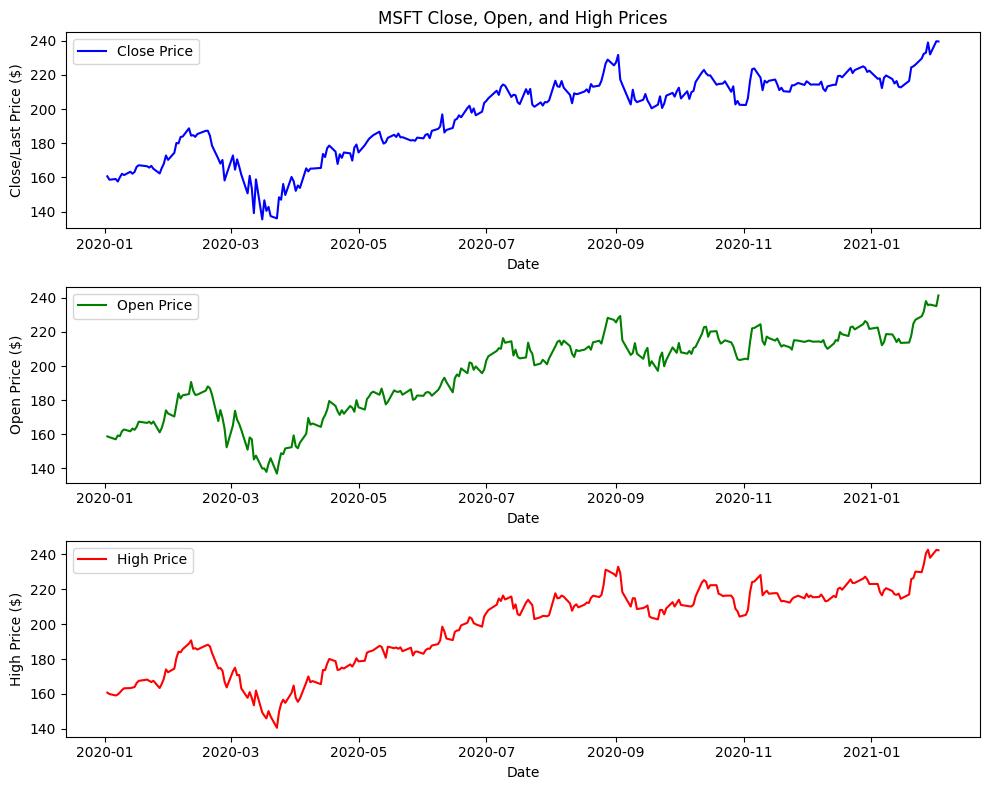

In [146]:
# Load your data into a DataFrame
df = pd.read_csv('/content/MSFT_1_2_20_to_2_2_21.csv')

# Parse the 'Date' column into datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df = df.sort_values('Date').reset_index(drop=True)

# Extract and clean columns as a NumPy array
data_Close = df['Close/Last'].str.replace('$', '').astype(float).values
data_Open = df['Open'].str.replace('$', '').astype(float).values
data_High = df['High'].str.replace('$', '').astype(float).values

# Visualize the data
plt.figure(figsize=(10, 8))

# Close/Last Price plot
plt.subplot(3, 1, 1)
plt.plot(df['Date'], data_Close, label='Close Price', color='blue')
plt.title('MSFT Close, Open, and High Prices')
plt.xlabel('Date')
plt.ylabel('Close/Last Price ($)')
plt.legend()

# Open Price plot
plt.subplot(3, 1, 2)
plt.plot(df['Date'], data_Open, label='Open Price', color='green')
plt.xlabel('Date')
plt.ylabel('Open Price ($)')
plt.legend()

# High Price plot
plt.subplot(3, 1, 3)
plt.plot(df['Date'], data_High, label='High Price', color='red')
plt.xlabel('Date')
plt.ylabel('High Price ($)')
plt.legend()

plt.tight_layout()
plt.show()

# Combine data for consistent scaling across all features
combined_data = np.array([data_Close, data_Open, data_High]).T

# Initialize and fit a single scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(combined_data)

# Separate the scaled data back into individual features
data_Close_scaled = data_scaled[:, 0]
data_Open_scaled = data_scaled[:, 1]
data_High_scaled = data_scaled[:, 2]


# Store the scaler for later inverse transformation
scalers = {"all_features": scaler}

# Use the scaled data for sequence creation
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X_Close, y_Close = create_sequences(data_Close_scaled, seq_length)
X_Open, y_Open = create_sequences(data_Open_scaled, seq_length)
X_High, y_High = create_sequences(data_High_scaled, seq_length)

In [147]:
# Using the sequences generated in cell above
# Define test size
test_size = 0.2  # 20% for testing

# Split Close data
X_train_Close, X_test_Close, y_train_Close, y_test_Close = train_test_split(
    X_Close, y_Close, test_size=test_size, shuffle=False
)

# Split Open data
X_train_Open, X_test_Open, y_train_Open, y_test_Open = train_test_split(
    X_Open, y_Open, test_size=test_size, shuffle=False
)

# Split High data
X_train_High, X_test_High, y_train_High, y_test_High = train_test_split(
    X_High, y_High, test_size=test_size, shuffle=False
)

# Convert to tensors
# Close data
X_train_Close_tensor = torch.tensor(X_train_Close, dtype=torch.float32).unsqueeze(-1)
y_train_Close_tensor = torch.tensor(y_train_Close, dtype=torch.float32)

X_test_Close_tensor = torch.tensor(X_test_Close, dtype=torch.float32).unsqueeze(-1)
y_test_Close_tensor = torch.tensor(y_test_Close, dtype=torch.float32)

# Open data
X_train_Open_tensor = torch.tensor(X_train_Open, dtype=torch.float32).unsqueeze(-1)
y_train_Open_tensor = torch.tensor(y_train_Open, dtype=torch.float32)

X_test_Open_tensor = torch.tensor(X_test_Open, dtype=torch.float32).unsqueeze(-1)
y_test_Open_tensor = torch.tensor(y_test_Open, dtype=torch.float32)

# High data
X_train_High_tensor = torch.tensor(X_train_High, dtype=torch.float32).unsqueeze(-1)
y_train_High_tensor = torch.tensor(y_train_High, dtype=torch.float32)

X_test_High_tensor = torch.tensor(X_test_High, dtype=torch.float32).unsqueeze(-1)
y_test_High_tensor = torch.tensor(y_test_High, dtype=torch.float32)

In [148]:
# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=1, num_layers=1, dropout=0):
        super(SimpleLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer with dropout
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the outputs from the last time step
        out = self.fc(out[:, -1, :])
        return out



In [149]:
# Train the model
num_epochs = 200 #200
learning_rate = 0.0005 #0.0005

# Create dictionaries to hold models, optimizers, losses, and data for each feature
models = {
    "Close": SimpleLSTM(hidden_size=256, num_layers=2, dropout=0.2), #256
    "Open":SimpleLSTM(hidden_size=256, num_layers=2, dropout=0.2),
    "High": SimpleLSTM(hidden_size=256, num_layers=2, dropout=0.2)
}

optimizers = {
    "Close": optim.Adam(models["Close"].parameters(), lr=learning_rate),
    "Open": optim.Adam(models["Open"].parameters(), lr=learning_rate),
    "High": optim.Adam(models["High"].parameters(), lr=learning_rate)
}

# Criterion
criterion = nn.MSELoss()

# Initialize lists to store training and validation losses for each feature
train_losses = {"Close": [], "Open": [], "High": []}
val_losses = {"Close": [], "Open": [], "High": []}

# Data for each feature
data = {
    "Close": (X_train_Close_tensor, y_train_Close_tensor, X_test_Close_tensor, y_test_Close_tensor),
    "Open": (X_train_Open_tensor, y_train_Open_tensor, X_test_Open_tensor, y_test_Open_tensor),
    "High": (X_train_High_tensor, y_train_High_tensor, X_test_High_tensor, y_test_High_tensor)
}

# Training loop
for feature in ["Close", "Open", "High"]:
    print(f"Training model for {feature} prices")

    # Extract the corresponding model, optimizer, and data
    model = models[feature]
    optimizer = optimizers[feature]
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = data[feature]

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

        # Track training loss
        train_losses[feature].append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
            val_losses[feature].append(val_loss.item())

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Training model for Close prices
Epoch [10/200], Loss: 0.0684, Val Loss: 0.0052
Epoch [20/200], Loss: 0.0475, Val Loss: 0.1043
Epoch [30/200], Loss: 0.0360, Val Loss: 0.0206
Epoch [40/200], Loss: 0.0276, Val Loss: 0.0436
Epoch [50/200], Loss: 0.0159, Val Loss: 0.0176
Epoch [60/200], Loss: 0.0080, Val Loss: 0.0109
Epoch [70/200], Loss: 0.0070, Val Loss: 0.0034
Epoch [80/200], Loss: 0.0069, Val Loss: 0.0033
Epoch [90/200], Loss: 0.0063, Val Loss: 0.0028
Epoch [100/200], Loss: 0.0059, Val Loss: 0.0028
Epoch [110/200], Loss: 0.0058, Val Loss: 0.0031
Epoch [120/200], Loss: 0.0055, Val Loss: 0.0027
Epoch [130/200], Loss: 0.0053, Val Loss: 0.0028
Epoch [140/200], Loss: 0.0053, Val Loss: 0.0028
Epoch [150/200], Loss: 0.0050, Val Loss: 0.0027
Epoch [160/200], Loss: 0.0052, Val Loss: 0.0027
Epoch [170/200], Loss: 0.0048, Val Loss: 0.0029
Epoch [180/200], Loss: 0.0049, Val Loss: 0.0027
Epoch [190/200], Loss: 0.0044, Val Loss: 0.0026
Epoch [200/200], Loss: 0.0045, Val Loss: 0.0026
Training model fo

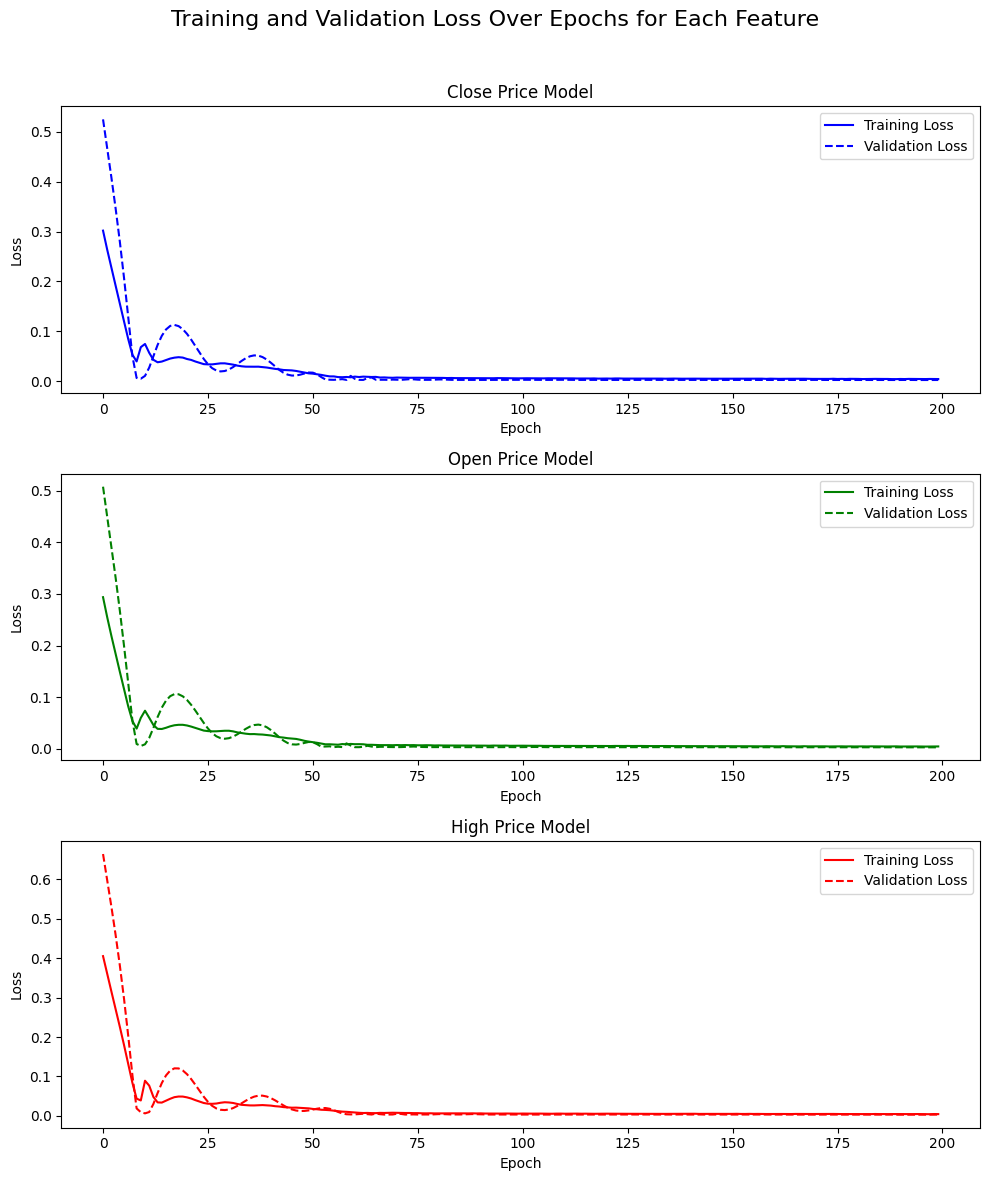

In [150]:
# Plot training and validation loss
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Training and Validation Loss Over Epochs for Each Feature', fontsize=16)

# Plot for 'Close' model
axes[0].plot(train_losses["Close"], label='Training Loss', color='blue')
axes[0].plot(val_losses["Close"], label='Validation Loss', linestyle='--', color='blue')
axes[0].set_title('Close Price Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for 'Open' model
axes[1].plot(train_losses["Open"], label='Training Loss', color='green')
axes[1].plot(val_losses["Open"], label='Validation Loss', linestyle='--', color='green')
axes[1].set_title('Open Price Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Plot for 'High' model
axes[2].plot(train_losses["High"], label='Training Loss', color='red')
axes[2].plot(val_losses["High"], label='Validation Loss', linestyle='--', color='red')
axes[2].set_title('High Price Model')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

# Leaving space for the main title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Evaluating model for Close prices
Close Training Set MSE: 48.0756
Close Testing Set MSE: 28.2235


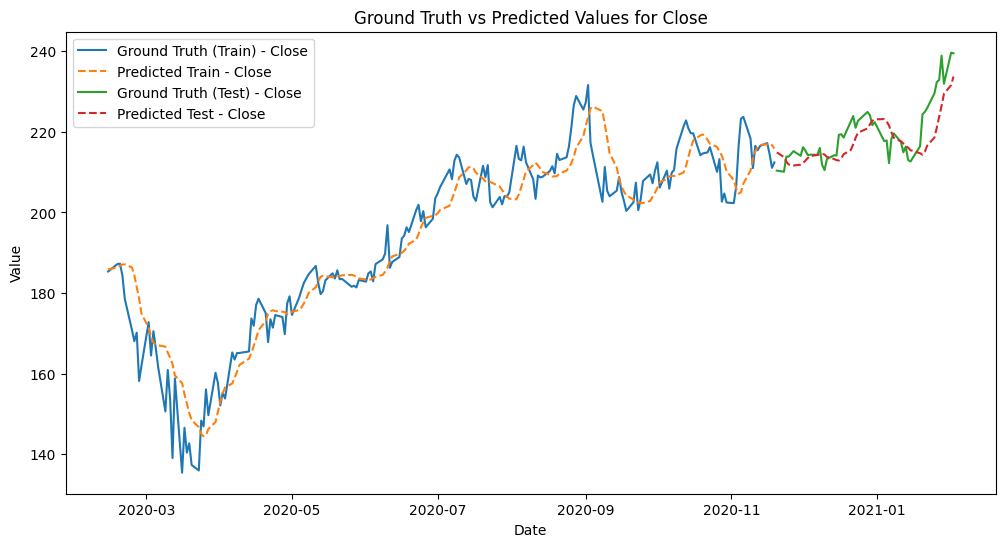

Evaluating model for Open prices
Open Training Set MSE: 46.1359
Open Testing Set MSE: 29.5539


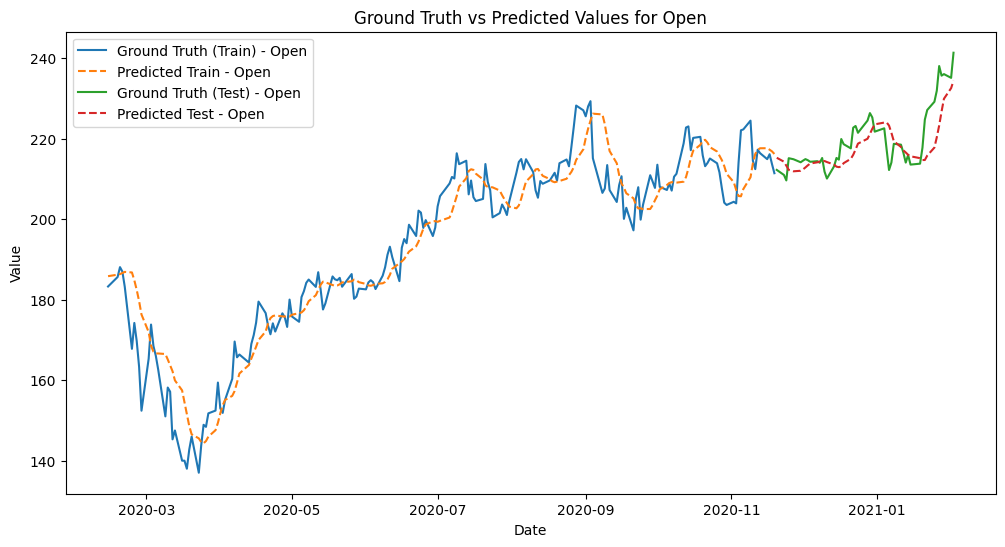

Evaluating model for High prices
High Training Set MSE: 45.0685
High Testing Set MSE: 34.2393


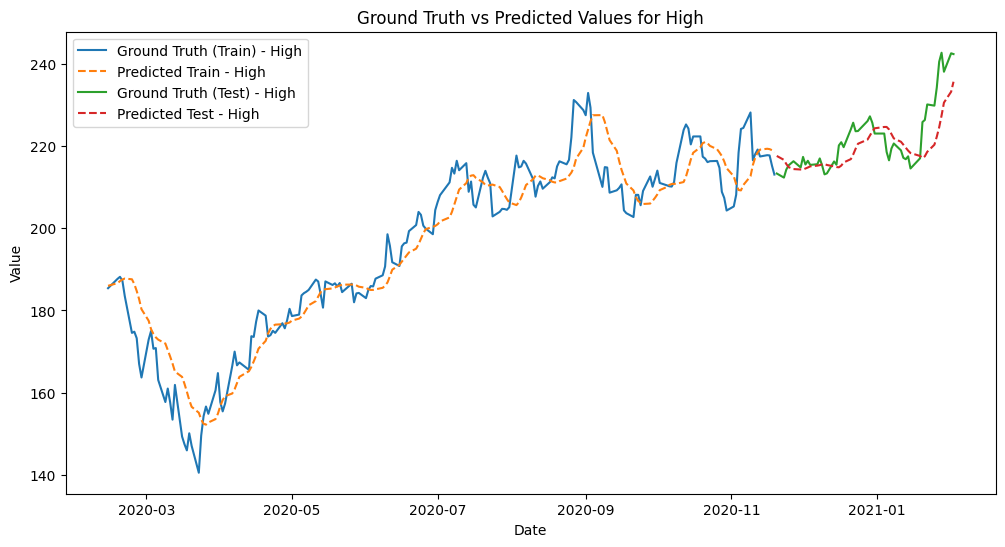

In [151]:
# Evaluate the model
features = ["Close", "Open", "High"]

# Retrieve the combined scaler
scaler = scalers["all_features"]

# Evaluation loop for each feature
for i, feature in enumerate(features):
    print(f"Evaluating model for {feature} prices")

    # Retrieve the model and data tensors for the current feature
    model = models[feature]
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = data[feature]

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Predict on training and test data
        train_pred = model(X_train_tensor).squeeze().numpy()
        test_pred = model(X_test_tensor).squeeze().numpy()

    # Prepare data for inverse transformation
    train_pred_stack = np.zeros((len(train_pred), 3))
    test_pred_stack = np.zeros((len(test_pred), 3))
    y_train_stack = np.zeros((len(y_train_tensor), 3))
    y_test_stack = np.zeros((len(y_test_tensor), 3))

    # Place predictions and actual values in the correct column (0, 1, or 2 for Close, Open, or High)
    train_pred_stack[:, i] = train_pred
    test_pred_stack[:, i] = test_pred
    y_train_stack[:, i] = y_train_tensor.numpy()
    y_test_stack[:, i] = y_test_tensor.numpy()

    # Inverse transform the predictions and GT values
    train_pred_inv = scaler.inverse_transform(train_pred_stack)[:, i]
    y_train_inv = scaler.inverse_transform(y_train_stack)[:, i]
    test_pred_inv = scaler.inverse_transform(test_pred_stack)[:, i]
    y_test_inv = scaler.inverse_transform(y_test_stack)[:, i]

    # Compute Mean Squared Error (MSE)
    train_mse = mean_squared_error(y_train_inv, train_pred_inv)
    test_mse = mean_squared_error(y_test_inv, test_pred_inv)
    print(f'{feature} Training Set MSE: {train_mse:.4f}')
    print(f'{feature} Testing Set MSE: {test_mse:.4f}')

    # Correct date ranges for plotting
    dates_train = df['Date'].iloc[seq_length:seq_length + len(y_train_inv)]
    dates_test = df['Date'].iloc[seq_length + len(y_train_inv):seq_length + len(y_train_inv) + len(y_test_inv)]

    # Plot GT vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train_inv, label=f'Ground Truth (Train) - {feature}')
    plt.plot(dates_train, train_pred_inv, label=f'Predicted Train - {feature}', linestyle='--')
    plt.plot(dates_test, y_test_inv, label=f'Ground Truth (Test) - {feature}')
    plt.plot(dates_test, test_pred_inv, label=f'Predicted Test - {feature}', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Ground Truth vs Predicted Values for {feature}')
    plt.legend()
    plt.show()

In [152]:
def predict_future(model, initial_sequence, future_steps, scaler, feature_index):

    model.eval()
    predictions = []
    current_sequence = initial_sequence.tolist()

    for _ in range(future_steps):
        # Prepare the input sequence by reshaping to (1, seq_length, 1)
        input_seq = np.array(current_sequence[-seq_length:]).reshape(1, seq_length, 1)
        input_tensor = torch.tensor(input_seq, dtype=torch.float32)

        with torch.no_grad():
            prediction = model(input_tensor)

        # Extract the predicted value and add it to the sequence
        pred_value = prediction.item()
        current_sequence.append(pred_value)  # Use the predicted value as part of the next input sequence
        predictions.append(pred_value)

    # Inverse transform predictions
    if scaler is not None:
        # We must fit predictions into a 3-column array for inverse transformation with the scaler
        pred_stack = np.zeros((len(predictions), 3))
        pred_stack[:, feature_index] = predictions  # Populate only the relevant feature column

        # Inverse transform and extract only the relevant feature column
        predictions = scaler.inverse_transform(pred_stack)[:, feature_index]

    return predictions

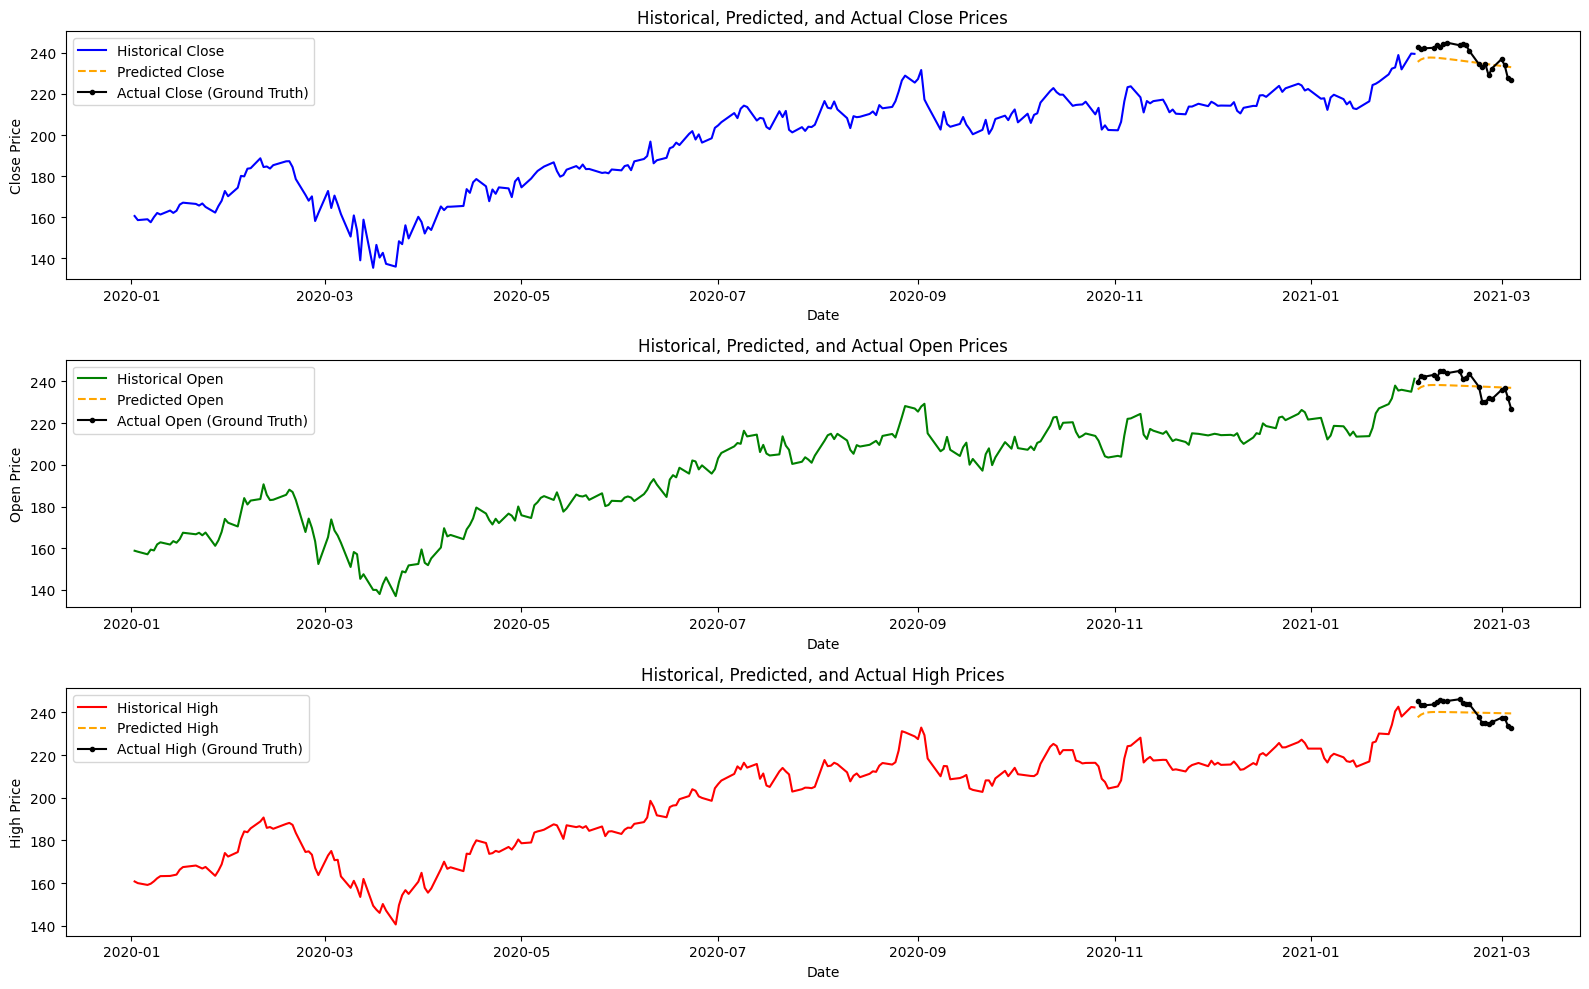

In [153]:

# Generate future predictions
future_steps = 30  # Predict the next 30 days

# Prepare initial sequences for each feature using the last sequence from the scaled data
initial_sequence_close = data_scaled[-seq_length:, 0]  # "Close" feature
initial_sequence_open = data_scaled[-seq_length:, 1]   # "Open" feature
initial_sequence_high = data_scaled[-seq_length:, 2]   # "High" feature

# Predict future values for each feature
predictions_close = predict_future(
    model=models["Close"],
    initial_sequence=initial_sequence_close,
    future_steps=future_steps,
    scaler=scalers["all_features"],
    feature_index=0
)
predictions_open = predict_future(
    model=models["Open"],
    initial_sequence=initial_sequence_open,
    future_steps=future_steps,
    scaler=scalers["all_features"],
    feature_index=1
)
predictions_high = predict_future(
    model=models["High"],
    initial_sequence=initial_sequence_high,
    future_steps=future_steps,
    scaler=scalers["all_features"],
    feature_index=2
)

future_steps = 30

# Prepare initial sequences for each feature using the last sequence from scaled data
initial_sequence_close = data_scaled[-seq_length:, 0]  # "Close" feature
initial_sequence_open = data_scaled[-seq_length:, 1]   # "Open" feature
initial_sequence_high = data_scaled[-seq_length:, 2]   # "High" feature

# Predict future values for each feature
predictions_close = predict_future(model=models["Close"], initial_sequence=initial_sequence_close, future_steps=future_steps, scaler=scalers["all_features"], feature_index=0)
predictions_open = predict_future(model=models["Open"], initial_sequence=initial_sequence_open, future_steps=future_steps, scaler=scalers["all_features"], feature_index=1)
predictions_high = predict_future(model=models["High"], initial_sequence=initial_sequence_high, future_steps=future_steps, scaler=scalers["all_features"], feature_index=2)

# Generate future dates for predictions
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Load and prepare the ground truth data for the predicted period
truth_data_df = pd.read_csv('/content/HistoricalData_2_3_21_to_3_4_21.csv')
truth_data_df['Date'] = pd.to_datetime(truth_data_df['Date'])  # Ensure dates are in datetime format
truth_data_df = truth_data_df.sort_values('Date').reset_index(drop=True)

# Clean up currency symbols and convert to floats
data_Close = df['Close/Last'].str.replace('$', '').astype(float).values
data_Open = df['Open'].str.replace('$', '').astype(float).values
data_High = df['High'].str.replace('$', '').astype(float).values

# Ground truth data for the prediction period
ground_truth_close = truth_data_df['Close/Last'].str.replace('$', '').astype(float).values
ground_truth_open = truth_data_df['Open'].str.replace('$', '').astype(float).values
ground_truth_high = truth_data_df['High'].str.replace('$', '').astype(float).values
ground_truth_dates = truth_data_df['Date']

# Concatenate historical and future data for continuous plotting
historical_dates = df['Date']

# Plot the results for each feature
plt.figure(figsize=(16, 10))

# Plot Close
plt.subplot(3, 1, 1)
plt.plot(historical_dates, data_Close, label='Historical Close', color='blue')  # Historical data
plt.plot(future_dates, predictions_close, label='Predicted Close', linestyle='--', color='orange')  # Predicted data
plt.plot(ground_truth_dates, ground_truth_close, label='Actual Close (Ground Truth)', color='black', marker='.')  # Ground truth
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical, Predicted, and Actual Close Prices')
plt.legend()

# Plot Open
plt.subplot(3, 1, 2)
plt.plot(historical_dates, data_Open, label='Historical Open', color='green')  # Historical data
plt.plot(future_dates, predictions_open, label='Predicted Open', linestyle='--', color='orange')  # Predicted data
plt.plot(ground_truth_dates, ground_truth_open, label='Actual Open (Ground Truth)', color='black', marker='.')  # Ground truth
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Historical, Predicted, and Actual Open Prices')
plt.legend()

# Plot High
plt.subplot(3, 1, 3)
plt.plot(historical_dates, data_High, label='Historical High', color='red')  # Historical data
plt.plot(future_dates, predictions_high, label='Predicted High', linestyle='--', color='orange')  # Predicted data
plt.plot(ground_truth_dates, ground_truth_high, label='Actual High (Ground Truth)', color='black', marker='.')  # Ground truth
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('Historical, Predicted, and Actual High Prices')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
